<p style="text-align: right">
  <img src="https://github.com/duckietown/mooc-exercises/blob/daffy/visual_lane_servoing/solution/images/dtlogo.png?raw=1" alt="Logo" width="200">
</p>

# 💻🚙 05 - Visual control

<figure>
  <div style="text-align:center;">
  <img src="https://github.com/duckietown/mooc-exercises/blob/daffy/visual_lane_servoing/solution/images/visual_control/pic1_rect.png?raw=1", width=400px>
  <figcaption>The view from a Duckiebot when centered in its lane.</figcaption>
  </div>
</figure>

Now, we will combine the image processing tools that we have explored with the earlier exercise on image-based reactive control to design a policy for lane-following. Consider above image taken from the Duckiebot's camera when the Duckiebot was roughly centered in its lane. Our goal is to design a control policy that uses only images streamed from the Duckiebot's camera to keep it in the lane as it drives forward at a fixed velocity. 

Rather than design a controller that reasons over the raw image, we will process the image to enhance aspects of the image that are helpful for lane-following. In particular, the dashed-yellow and solid-white lane markings provide valuable cues that we can use to guide the robot on order to stay in its lane. 

Assume that the Duckiebot starts out in the center of its lane, facing in the direction of travel. Assume also that the Duckiebot is traveling forward at a nominal speed. We can imagine using the location of the dashed-yellow and solid-white lane markings in the image to vary the rotational velocities of the left and right wheels in order to stay in the lane. For example, if the dashed-yellow lane markings appear in the left- and right-halves of the image, we might command a negative rotational velocity (i.e., counter-clockwise) as a correction. 

Of course, this requires that we can detect the dashed-yellow and solid-white lane markings and estimate their orientations. Thus, we want to apply a filter that makes the lane markings "pop out" in the image, while supressing as much of distracting content of the image. As we discussed in lecture, lane markings are brightly colored against a dark background (the road). 

We can identify the location of lane markings in the image by applying finite-difference filters $h_x$ and $h_y$ (e.g., using the Sobel operator) to estimate the horizontal and vertical intensity gradients

$$ \nabla I[u,v] = 
\begin{bmatrix}
G_x[u,v]\\
G_y[u,v]
\end{bmatrix}
$$

where

$$ 
\begin{align}
G_x = h_x * I\\
G_y = h_y * I
\end{align}
$$

We can then look for regions of the image where the magnitude of the intensity gradient is large as a measure of the strength of each edge.

$$ 
\lvert \nabla I[u,v] \rvert = \sqrt{\left(G_x[u,v]\right)^2 + \left(G_y[u,v]\right)^2}
$$

Assuming that these edges correspond to the lane boundaries, the direction of the gradients can then be used to estimate the desired orientations.

$$
\theta[u,v] = \textrm{atan2}\left(G_y[u,v], G_x[u,v]\right)
$$

In this exercise, we will develop this idea by investigating different ways of processing the images to tease out information about the robot's pose relative to the lane. We will use these results to implement a reactive image-space controller that we will validate on a simulated and/or real DuckieBot.

In [1]:
## Run this cell to import relevant modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

Populating the interactive namespace from numpy and matplotlib


Let's load the image as well as the homography for the corresponding camera into Python.

In [2]:
# Load in the image and generate hsv and grayscale versions
imgbgr = cv2.imread('pic1_rect.png')

# OpenCV uses BGR by default, whereas matplotlib uses RGB, so we generate an RGB version for the sake of visualization
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for any color-based filtering
imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

# Most of our operations will be performed on the grayscale version
img = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

## Detecting Lane Markings using Sobel Edge Detection

Now, let's apply the Sobel operator to the image to identify image gradients.

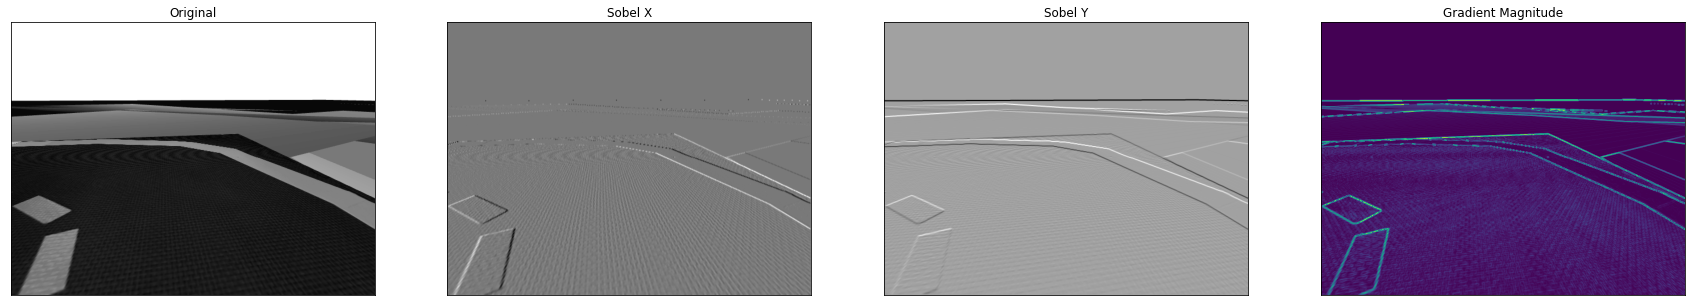

In [3]:
# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1)

# Compute the magnitude of the gradients
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)

# Compute the orientation of the gradients
Gdir = cv2.phase(np.array(sobelx, np.float32), np.array(sobely, dtype=np.float32), angleInDegrees=True)

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.uint8(Gmag))
ax4.set_title('Gradient Magnitude'), ax4.set_xticks([]), ax4.set_yticks([]);

Filtering the image has enhanced the location of the lane markings, but has also emphasized other locations where there are rapid changes in intensity. These include the duckies, buildings in Duckietown, the road surface, and elements in the background (e.g., the lights in the upper-right corner of the image). Note that we are using a non-grayscale colormap for the gradient magnitudes in order to more clearly convey locations that are enhanced by the Sobel operator.

We can reduce the occurrence of some of these features by first blurring the filter using a Gaussian kernel.

## Gaussian Blurring

The Sobel operator picks up on noise in the image as well as texture in the scene that we don't particularly care about. We can blur the image with a Gaussian kernel to reduce these spurious detections.

### Example: Gaussian Blurring

Using your experience from the previous exercise, identify a setting for the standard deviation of the Gaussian kernel that removes noise and local texture (e.g., that of the road surface), without sacrificing too much valid content (namely, the edges associated with lane markings)

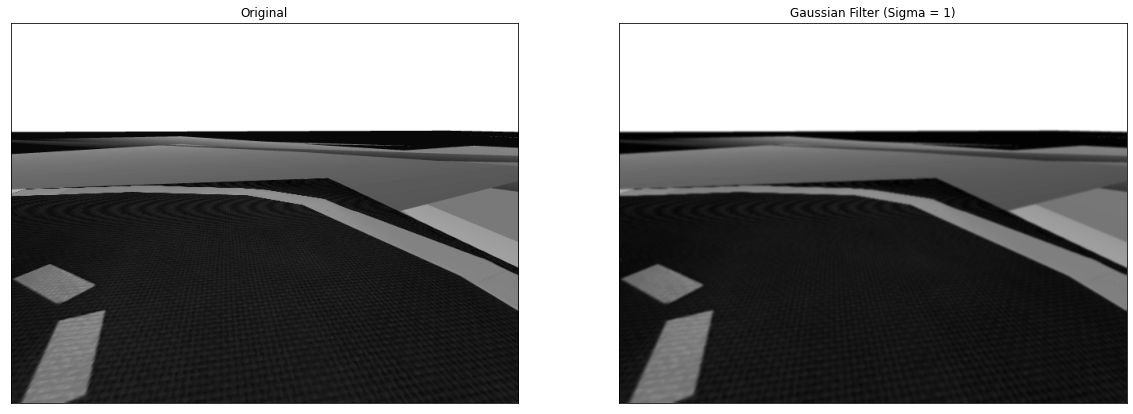

In [4]:
# TODO: Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.
sigma = 1 # CHANGE ME

# Smooth the image using a Gaussian kernel
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

# Visualize the filtered image alongside the original image.
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);

Now, let's look at the gradients of the blurred image. For this exercise, experiment with different settings for the standard deviation above and see how they affect the image gradients. In particular, compare the gradients for two extremes of the standard deviation (e.g., $\sigma=1$ and $\sigma=10$).

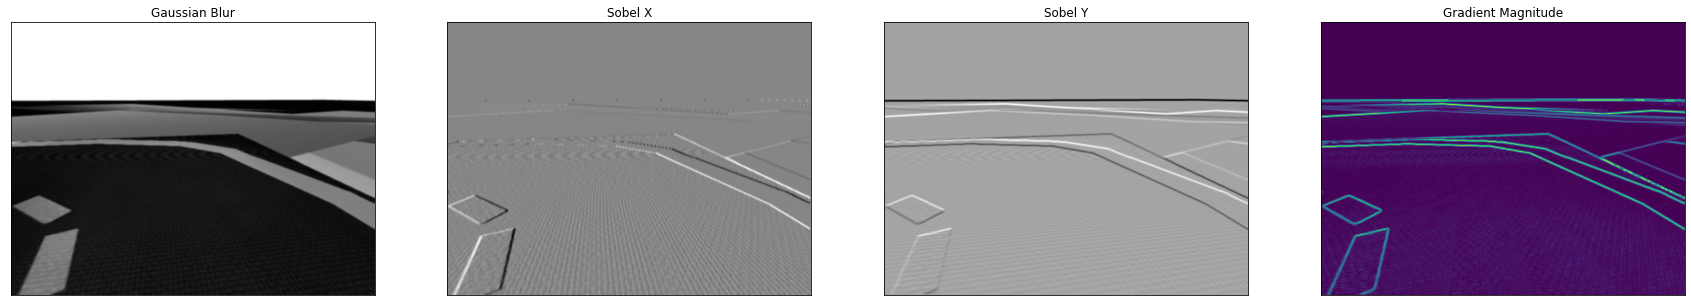

In [5]:
# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,0,1)

# Compute the magnitude of the gradients
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)

# Compute the orientation of the gradients
Gdir = cv2.phase(np.array(sobelx, np.float32), np.array(sobely, dtype=np.float32), angleInDegrees=True)

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img_gaussian_filter,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.uint8(Gmag))
ax4.set_title('Gradient Magnitude'), ax4.set_xticks([]), ax4.set_yticks([]);

## A Varient of Non-maximal Supression

With a suitable choice for the standard deviation, we have smoothed out some of the noise and texture in the image (e.g., the road), reducing the number of candidate edges while preserving most of the edges that corresopnd to lane markings.

Under the assumption that the edges associated with lane markings are stronger than most of the edges in the image (in terms of the magnitude of the gradients), we can further eliminate distractors by only keeping edges whose gradient magnitude is greater than a threshold. 

### Example: A form of non-maximal supression

In this exercise, we will take a look at the histogram over gradient magnitudes to better understand the distribution of gradient magnitudes. Based on the histogram, we can choose a magnitude threshold that we will use to filter out weaker edges.

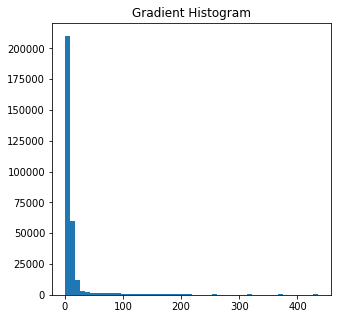

In [6]:
# Visualize the histogram over gradient magnitudes
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.hist((Gmag).flatten(), bins=50)
ax1.set_title('Gradient Histogram');

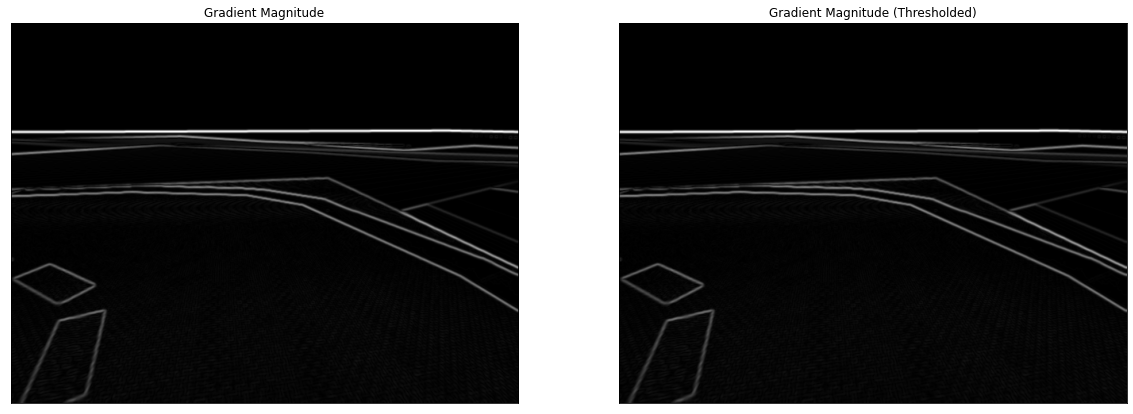

In [7]:
# TODO: Use the histogram above to choose the minimum threshold on the gradient magnitude. 
#       Edges whos gradient magnitude is below this threshold will be filtered out.
threshold = np.random.rand(1,1) # CHANGE ME

mask_mag = (Gmag > threshold)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Gmag, cmap = 'gray')
ax1.set_title('Gradient Magnitude'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Thresholded)'), ax2.set_xticks([]), ax2.set_yticks([]);

## Color-based Masking

Having identified a candidate set of edges, we can now try design a set of masks that isolate the edges associated with the dashed-yellow and solid-white lane markings.

Perhaps the most obvious thing to do is to create masks that filter out pixels whose color differs from that of the yellow and white lines. 

### Example: Color-based Masking

Following what we did in the Braitenberg exercise, we can select upper- and lower-bounds on the HSV values for the two lines. One option mentioned in the Braitenberg exercise is to use [this online color picker](https://pinetools.com/image-color-picker), which allows us to get the HSV values for particular pixels. 

**Note**: When we go to use these bounds, remember that OpenCV uses uses the convention that $\textrm{H} \in [0, 179]$, $\textrm{S} \in [0, 255]$, and $\textrm{V} \in [0, 255]$, while other tools may use different ranges (e.g., Gimp uses $\textrm{H} \in [0, 360]$, $\textrm{S} \in [0, 100]$, and $\textrm{V} \in [0, 100])$.

**Note**: While the HSV color space provides a better representation (e.g., compared to RGB) for color-based detection, the appearance of the yellow and white lane markings will change due to variations in illumination, shading, etc. for In order to improve the generalizability of these bounds, you are encouraged to also consider the `../images/visual_control/pic3_rect.png` image and define bounds that are appropriate for both.

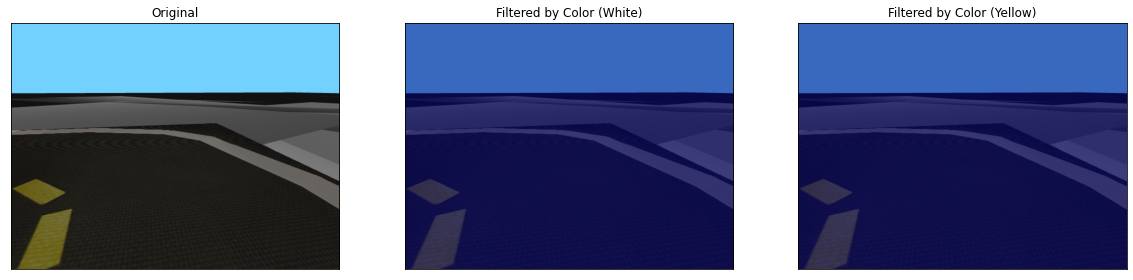

In [21]:
# Using the above tool, we can identify the bounds as follows
# TODO: Identify the lower and upper HSV bounds for the white and yellow lane markings
#       These values represent the maximum range, so they don't filter out anything
white_lower_hsv = np.array([0, 0, 0])         # CHANGE ME
white_upper_hsv = np.array([255, 255, 255])   # CHANGE ME
yellow_lower_hsv = np.array([0, 0, 0])        # CHANGE ME
yellow_upper_hsv = np.array([255, 255, 255])  # CHANGE ME

mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(imgrgb)
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(imgrgb)
ax2.imshow(mask_white, cmap='jet', alpha=0.5)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(imgrgb)
ax3.imshow(mask_yellow, cmap='jet', alpha=0.5)
ax3.set_title('Filtered by Color (Yellow)'), ax3.set_xticks([]), ax3.set_yticks([]);

## Edge-based Masking

Now, we will explore possible ways to mask out unwanted edges based upon their orientation in the image.

Assuming that the Duckiebot hasn't deviated too much from its lane, most of the dashed-yellow line should lie in the left-half of the image, while most of the solid-white line should lie in the right-half of the image. We can use this to reason separately over dashed-yellow and solid-white lane markings.

**Note**: While this masking may seem reasonable when the Duckiebot is oriented close to the direction of travel, it may not be what we want when the Duckiebot's orientation is off. In these cases, we would expect some of the dashed-yellow lane markings to be in the right-half of the image or some of the solid-white lane markings to be in the left-half of the image. These would be valuable cues to use. Thus, as you experiment with the included images as well as in simulation and on your physical Duckiebot, you may want to try disabling these masks.

### Example: Edge-based Masking

In [9]:
# Let's create masks for the left- and right-halves of the image
width = img.shape[1]
mask_left = np.ones(sobelx.shape)
mask_left[:,width // 2:] = 0
mask_right = np.ones(sobelx.shape)
mask_right[:,:width // 2] = 0

The inner edge of the dashed-yellow line corresponds to a negative gradient in the $x$- and $y$-directions, while the inner-edge of the solid-white line corresponds to a positive gradient in the $x$-direction and negative gradient in the $y$-direction. We can use this to further mask out unwanted edges.

In [10]:
# In the left-half image, we are interested in the right-half of the dashed yellow line, which corresponds to negative x- and y-derivatives
# In the right-half image, we are interested in the left-half of the solid white line, which correspons to a positive x-derivative and a negative y-derivative
# Generate a mask that identifies pixels based on the sign of their x-derivative
mask_sobelx_pos = (sobelx > 0)
mask_sobelx_neg = (sobelx < 0)
mask_sobely_pos = (sobely > 0)
mask_sobely_neg = (sobely < 0)

Now, lets combine these masks to see their effect on the edge detections, but let's look at the effects of the gradient-based masks before including those based on color.

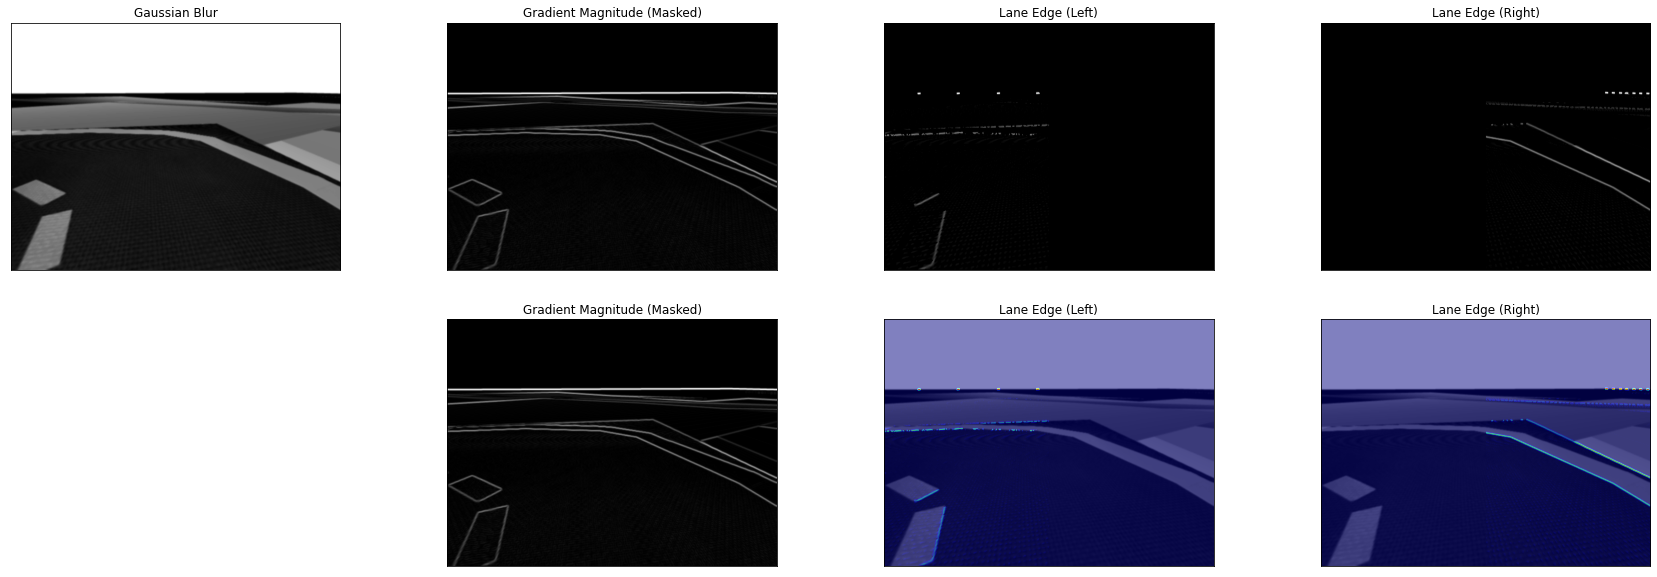

In [11]:
# Let's combine these masks with the gradient magnitude mask
mask_left_edge = mask_left * mask_mag * mask_sobelx_neg * mask_sobely_neg
mask_right_edge = mask_right * mask_mag * mask_sobelx_pos * mask_sobely_neg

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(img_gaussian_filter,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(Gmag * mask_left_edge, cmap = 'gray')
ax3.set_title('Lane Edge (Left)'), ax3.set_xticks([]), ax3.set_yticks([])
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(Gmag * mask_right_edge,cmap = 'gray')
ax4.set_title('Lane Edge (Right)'), ax4.set_xticks([]), ax4.set_yticks([]);

ax6 = fig.add_subplot(2,4,6)
ax6.imshow(mask_mag*Gmag,cmap = 'gray')
ax6.set_title('Gradient Magnitude (Masked)'), ax6.set_xticks([]), ax6.set_yticks([])
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(img_gaussian_filter,cmap = 'gray')
ax7.imshow(Gmag * mask_left_edge, cmap='jet', alpha=0.5)
ax7.set_title('Lane Edge (Left)'), ax7.set_xticks([]), ax7.set_yticks([])
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(img_gaussian_filter,cmap = 'gray')
ax8.imshow(Gmag * mask_right_edge, cmap='jet', alpha=0.5)
ax8.set_title('Lane Edge (Right)'), ax8.set_xticks([]), ax8.set_yticks([]);

We see that the inclusion of (a simple version of) non-maximal supression together with masking based on the image gradients has helped to filter out many of the distractor edges. However, the "Lane Edge (Left)" gradients include edges that don't correspond to lane markings (i.e., the bright-to-dark transition at the edge of the road). The "Lane Edge (Right)" gradients better isolate the edge caused by the solid-white line.

### Example: Dominant Gradient Orientations

Now, we want to estimate the gradient orientations for the dashed-yellow and solid-white lane markings. To that end, let's look at the gradient histogram for the left edge and right edge images.

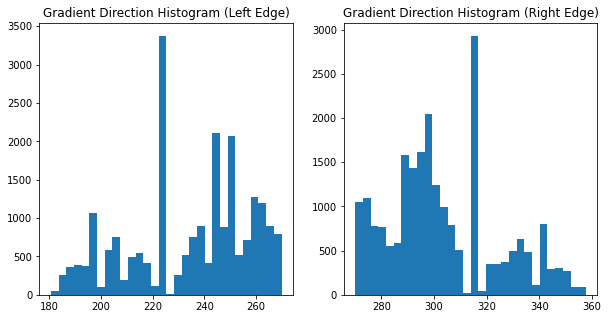

In [12]:
# Now, let's apply the mask to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.extract(mask_right_edge, Gdir).flatten(), bins=30)
ax2.set_title('Gradient Direction Histogram (Right Edge)');

Looking at the gradient histogram for the "Right Edge", we see that the large majority of the edges have an orientation around 315 degrees, while there are few outliers with orientations between 0 and 100 degrees and between 250 and 350 degrees. This is consistent with the gradients that we visualize above in the "Lane Edge (Right)" images above. The $\sim$315 degree orientation is consistent with the dominant edge associated with the solid-white lane marking (i.e., the gradient points to the upper-right).

Now, let's incorporate the color-based masks.

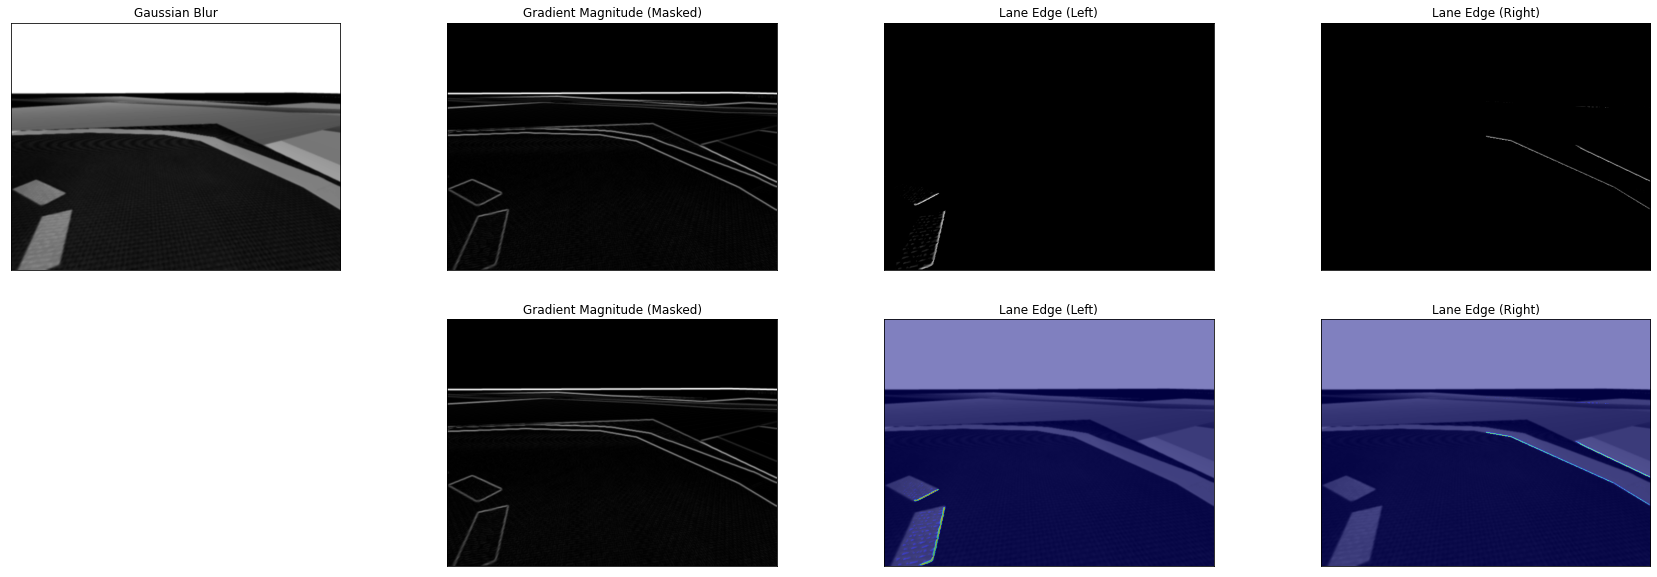

In [13]:
# Let's generate the complete set of masks, including those based on color
mask_left_edge = mask_left * mask_mag * mask_sobelx_neg * mask_sobely_neg * mask_yellow
mask_right_edge = mask_right * mask_mag * mask_sobelx_pos * mask_sobely_neg * mask_white

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(img_gaussian_filter,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(Gmag * mask_left_edge, cmap = 'gray')
ax3.set_title('Lane Edge (Left)'), ax3.set_xticks([]), ax3.set_yticks([])
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(Gmag * mask_right_edge,cmap = 'gray')
ax4.set_title('Lane Edge (Right)'), ax4.set_xticks([]), ax4.set_yticks([]);

ax6 = fig.add_subplot(2,4,6)
ax6.imshow(mask_mag*Gmag,cmap = 'gray')
ax6.set_title('Gradient Magnitude (Masked)'), ax6.set_xticks([]), ax6.set_yticks([])
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(img_gaussian_filter,cmap = 'gray')
ax7.imshow(Gmag * mask_left_edge, cmap='jet', alpha=0.5)
ax7.set_title('Lane Edge (Left)'), ax7.set_xticks([]), ax7.set_yticks([])
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(img_gaussian_filter,cmap = 'gray')
ax8.imshow(Gmag * mask_right_edge, cmap='jet', alpha=0.5)
ax8.set_title('Lane Edge (Right)'), ax8.set_xticks([]), ax8.set_yticks([]);

We can see that incorporating the color-based masks has removed most if not all of the outliers, but has also removed some of the valid edges, particularly those associated with the solid-white lane markings.

Let's look at the corresponding historgrams.

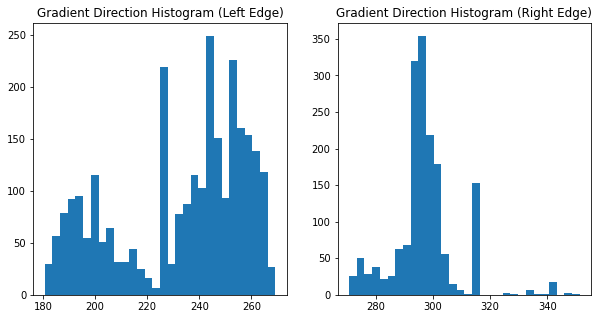

In [14]:
# Now, let's apply the full set of masks to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.extract(mask_right_edge, Gdir).flatten(), bins=30)
ax2.set_title('Gradient Direction Histogram (Right Edge)');

Consistent with what we saw above, incorporating the color-based masks has effectively removed the large number of edges that lead to a dominant mode around 260 degrees in the previous histogram for the left edge. Now, there is a single dominant mode for each of the edges.

Now, you might be wondering why we don't use these angles for control. Afterall, you might expect that we could use any deviations in the gradient orientations associated with the left and right lane markings in order to steer the vehicle back into the lane. However, the image-space orientations don't change significantly as the vehicle's orientation relative to the lane changes, implying that there isn't as much useful signal here as we might expect